In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.wkt
from shapely.geometry import MultiPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
!wget -qNP data https://data.rivm.nl/covid-19/COVID-19_aantallen_gemeente_cumulatief.csv

In [27]:
df = pd.read_csv("data\COVID-19_aantallen_gemeente_cumulatief.csv", sep=';')
datum = df.Date_of_report[len(df.Date_of_report)-1]
df.head()

,Date_of_report,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased
0,2020-03-13 10:00:00,GM0003,Appingedam,Groningen,0,0,0
1,2020-03-13 10:00:00,GM0010,Delfzijl,Groningen,0,0,0
2,2020-03-13 10:00:00,GM0014,Groningen,Groningen,3,0,0
3,2020-03-13 10:00:00,GM0024,Loppersum,Groningen,0,0,0
4,2020-03-13 10:00:00,GM0034,Almere,Flevoland,1,1,0


In [28]:
print("Aantal gemeenten:", df['Municipality_name'].unique().shape[0])
print("Totaal gemeld:", df[df.Date_of_report == datum]['Total_reported'].sum())
print("Total overleden:", df[df.Date_of_report == datum]['Deceased'].sum())

Aantal gemeenten: 356
Totaal gemeld: 272401
Total overleden: 6964


In [31]:
top10_reported = df[df.Date_of_report == datum][['Municipality_name', 'Total_reported']].sort_values('Total_reported', ascending=False).head(10).reset_index(drop=True)
top10_reported.index = np.arange(1, len(top10_reported) + 1)
top10_reported

,Municipality_name,Total_reported
1,Amsterdam,25936
2,Rotterdam,19612
3,'s-Gravenhage,13981
4,Utrecht,8413
5,Tilburg,3403
6,Eindhoven,3230
7,Nijmegen,3124
8,Groningen,3078
9,Almere,3029
10,Breda,2903


In [32]:
top10_deceased = df[df.Date_of_report == datum][['Municipality_name', 'Deceased']].sort_values('Deceased', ascending=False).head(10).reset_index(drop=True)
top10_deceased.index = np.arange(1, len(top10_deceased) + 1)
top10_deceased

,Municipality_name,Deceased
1,Rotterdam,410
2,'s-Gravenhage,314
3,Amsterdam,314
4,Tilburg,172
5,Maastricht,140
6,Meierijstad,134
7,Utrecht,124
8,Eindhoven,99
9,Oss,93
10,'s-Hertogenbosch,85


In [33]:
bins = [0, 1000, 1500, 2000, df['Total_reported'].max()]
labels = ['0-1000', '1000-1500', '1500-2000', '>2000']
df['binned'] = pd.cut(df['Total_reported'], bins=bins, labels=labels)
df[['Total_reported', 'binned']].head()

,Total_reported,binned
0,0,NaN
1,0,NaN
2,3,0-1000
3,0,NaN
4,1,0-1000


In [9]:
geometry = df['shape'].map(shapely.wkt.loads)
df = df.drop('shape', axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
gdf.drop(columns=['FID', 'datum_bestand'], inplace=True)

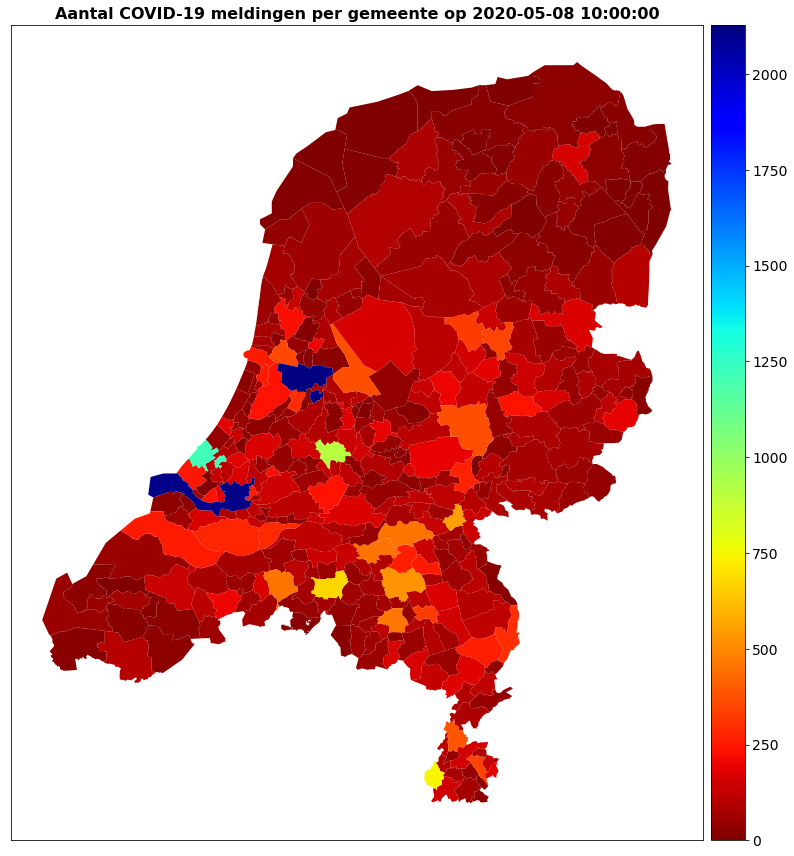

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot(column='totaal_gemeld', ax=ax, legend=True, cmap='jet_r', cax=cax)
ax.set_title(f"Aantal COVID-19 meldingen per gemeente op {datum}", fontsize=16, fontweight="bold")
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tick_params(axis="y", labelsize=14)
plt.show()

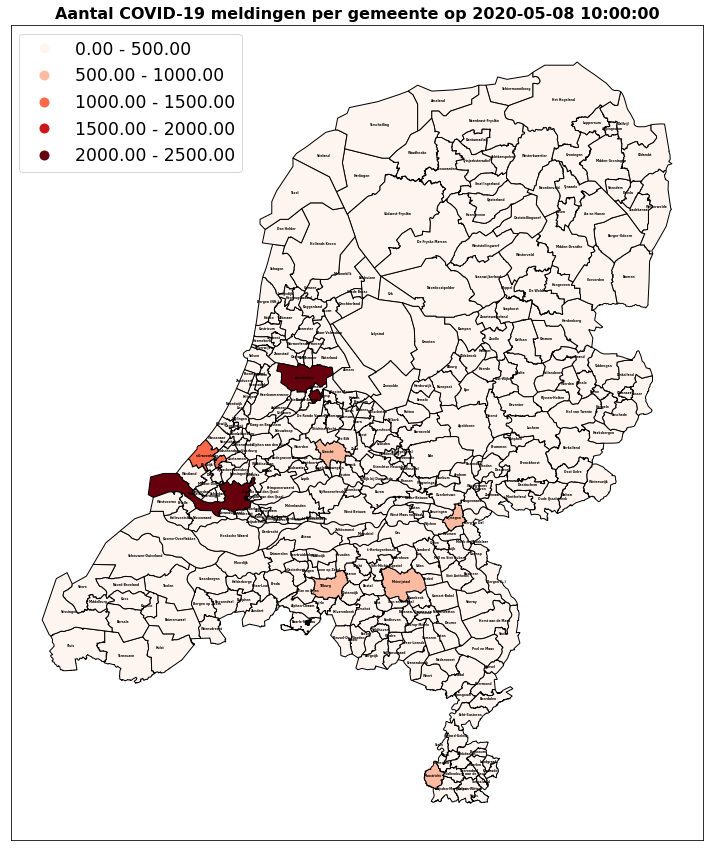

In [34]:
import mapclassify
bins = mapclassify.EqualInterval(np.linspace(0, 2500, 100), k=5).bins
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf.plot(column='totaal_gemeld', ax=ax, legend=True, \
         legend_kwds={'loc': 'upper left', 'fontsize':'xx-large'} \
         , scheme="User_Defined", cmap='Reds', classification_kwds=dict(bins=bins), edgecolor='black')

for x, y, label in zip(gdf.centroid.x, gdf.centroid.y, gdf.gemeente_naam):
    ax.annotate(label, xy=(x, y), xytext=(-10, 0), textcoords="offset points", fontsize=3, fontweight='bold')



ax.set_title(f"Aantal COVID-19 meldingen per gemeente op {datum}", fontdict={'fontsize': '16', \
                                                                             'fontweight' : 'bold'})
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig("covid-19_per_gemeente.pdf", bbox_inches='tight')